# Wine Quality Analysis ( Factor Analysis)

## Introduction

Wine quality is a multifaceted concept influenced by a variety of physicochemical attributes such as acidity, sugar content, pH, and alcohol. In this project, we aim to explore the underlying structure of these chemical measurements using factor analysis, an unsupervised technique that identifies latent variables (or "factors") driving observed patterns in the data. By reducing the dimensionality of our feature space, we can better understand the core dimensions that differentiate wines and assess how these dimensions relate to perceived quality.

Before introducing the quality label into our models, we deliberately exclude it during the early stages of the analysis. This is an intentional choice that allows us to avoid injecting label bias during factor extraction. The goal of unsupervised learning—particularly factor analysis—is to learn patterns independently of outcome variables. If quality were present during this stage, it could distort the latent factor structure, leading to circular reasoning when we later assess how well these factors explain quality. By keeping the label aside initially, we ensure a clean separation between pattern discovery and supervised evaluation.

In the second half of the notebook, we reintroduce quality to evaluate how well our latent dimensions align with human-perceived wine quality. We also use these factors to build predictive models and cluster wines into distinct profiles, ultimately providing both interpretable and actionable insights into what defines a good wine.

## Load Required Libraries

In [42]:
import os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing    import StandardScaler
from sklearn.decomposition    import FactorAnalysis
from sklearn.cluster          import KMeans
from sklearn.metrics          import silhouette_score
from sklearn.model_selection  import cross_val_score, GridSearchCV
import os

# Directory to save plots
FIG_DIR = r"C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures"

def save_plot(filename, tight=True, dpi=300):
    path = os.path.join(FIG_DIR, filename)
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"✅ Saved: {path}")



## Load & Clean Data
In this initial section of the analysis, we focus on loading, cleaning, and preparing the wine quality dataset for downstream statistical modeling. The dataset comprises two separate files: one for red wine and another for white wine, each containing physicochemical measurements and quality scores. After defining the appropriate file paths, both datasets are read into memory. The red wine dataset requires special handling due to embedded quotation marks, which is why we explicitly use the QUOTE_NONE parameter in pd.read_csv. Once loaded, we standardize the column names by stripping out quotation marks and excess whitespace using the clean_headers() function. This ensures consistency in variable naming for subsequent operations.

To facilitate comparative analysis, we introduce a categorical identifier by adding a type column to both datasets, marking each observation as either red or white wine. These datasets are then vertically concatenated into a single DataFrame. For ease of modeling, we encode wine type into a binary variable is_white, where 1 represents white wine and 0 represents red. The original string-based type column is dropped to avoid redundancy. Finally, in preparation for techniques like factor analysis, we remove the quality column from the feature set to prevent information leakage and ensure that unsupervised methods do not inadvertently learn from the target variable. The remaining features are standardized using z-score normalization, producing a scaled matrix X_scaled suitable for dimension reduction, clustering, and other multivariate techniques.

In [32]:
base_dir   = r"C:\\Users\\lukew\\OneDrive\\Desktop\\Lukas\\Python\\wine-quality-analysis\\data"
red_path   = os.path.join(base_dir, "winequality-red.csv")
white_path = os.path.join(base_dir, "winequality-white.csv")

red   = pd.read_csv(red_path, sep=';', engine='python', quoting=csv.QUOTE_NONE)
white = pd.read_csv(white_path, sep=';')

# Clean headers
def clean_headers(df):
    df.columns = df.columns.str.replace('"','', regex=False).str.strip()
    return df
red, white = clean_headers(red), clean_headers(white)

# Combine
red['type'], white['type'] = 'red','white'
df = pd.concat([red, white], ignore_index=True)
df['is_white'] = (df['type']=='white').astype(int)
df.drop(columns='type', inplace=True)

#Preprocess 
X = df.drop(columns='quality')
scaler      = StandardScaler().fit(X)
X_scaled_np = scaler.transform(X)
X_scaled    = pd.DataFrame(X_scaled_np, columns=X.columns)

## Factor Analysis
In this section, we employ Factor Analysis using the FactorAnalyzer library to uncover latent structures in the physicochemical properties of the wine dataset. We extract three latent factors from the scaled feature matrix X_scaled, aiming to reduce dimensionality and reveal patterns among features such as acidity, alcohol content, and sulfur dioxide concentrations. These latent factors are intended to summarize complex, interrelated attributes into simpler, interpretable components.

To enhance interpretability, we apply Varimax rotation, an orthogonal rotation technique that maximizes the variance of squared loadings within each factor. This approach ensures that each feature loads heavily onto a single factor while minimizing its contributions to others, helping to identify cleaner and more distinct factor structures. Unlike our earlier custom rotation function, we now leverage the FactorAnalyzer's built-in Varimax rotation, which streamlines the process and ensures consistency with standard statistical routines.

The resulting rotated loadings heatmap clearly reveals three interpretable dimensions. For example, Factor 1 is dominated by strong negative loadings from features like is_white, total sulfur dioxide, and free sulfur dioxide, indicating it likely captures characteristics distinguishing white wines from red, particularly sulfur-related components. Factor 2 shows strong positive associations with density and residual sugar, potentially reflecting a sweetness or body-related dimension. Meanwhile, Factor 3 features high positive loadings for fixed acidity, citric acid, and volatile acidity, aligning with acidity and freshness-related traits.

C:\Users\lukew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Saved: C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures\fa_varimax_rotated_loadings.png


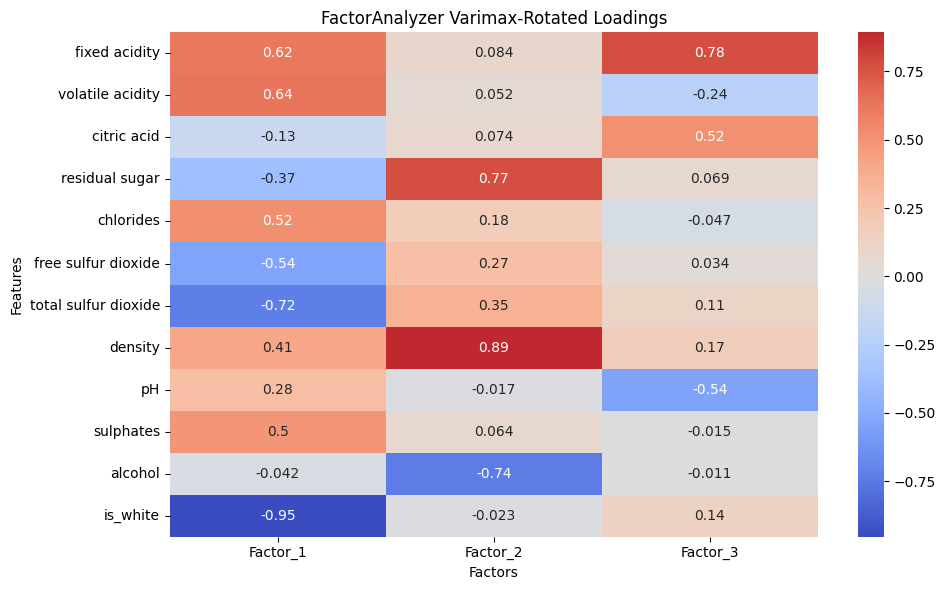

In [43]:
from factor_analyzer import FactorAnalyzer
n_factors = 3

# Fit FactorAnalyzer with Varimax rotation
fa_lib = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='ml')
fa_lib.fit(X_scaled)

# Get rotated loadings
fa_lib_loadings = pd.DataFrame(
    fa_lib.loadings_,
    index=X.columns,
    columns=[f"Factor_{i+1}" for i in range(n_factors)]
)

# Visualize
plt.figure(figsize=(10,6))
sns.heatmap(fa_lib_loadings, annot=True, cmap='coolwarm', center=0)
plt.title("FactorAnalyzer Varimax-Rotated Loadings")
plt.ylabel("Features")
plt.xlabel("Factors")
plt.tight_layout()

# Save plot
save_plot("fa_varimax_rotated_loadings.png")

plt.show()



## Visualization of Loading

# Attach Scores & Factor score by color
## Factor Scores by Wine Color

The factor score boxplots by wine color reveal clear differences in how red and white wines load on the extracted latent factors. For Factor 1, red wines exhibit significantly higher scores than white wines, indicating that this factor captures physicochemical characteristics that are more prevalent in red wines. These may include features such as higher levels of density, tannins, or specific acids known to vary between red and white varieties. Factor 2 displays relatively balanced distributions between the two wine types, though red wines tend to have slightly higher median scores. This suggests that Factor 2 captures more subtle differences, possibly related to volatile acidity or sulfur dioxide levels that vary within both groups. Interestingly, Factor 3 shows higher scores for white wines, implying this factor is associated with characteristics more dominant in white wine samples—potentially reflecting traits such as higher total sulfur dioxide or lower phenolic content. Overall, the visualization highlights that Factor Analysis successfully identifies latent dimensions that correspond to known distinctions between red and white wines, with Factor 1 emerging as the most discriminative component.

C:\Users\lukew\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Saved: C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures\factor_scores_by_wine_color.png


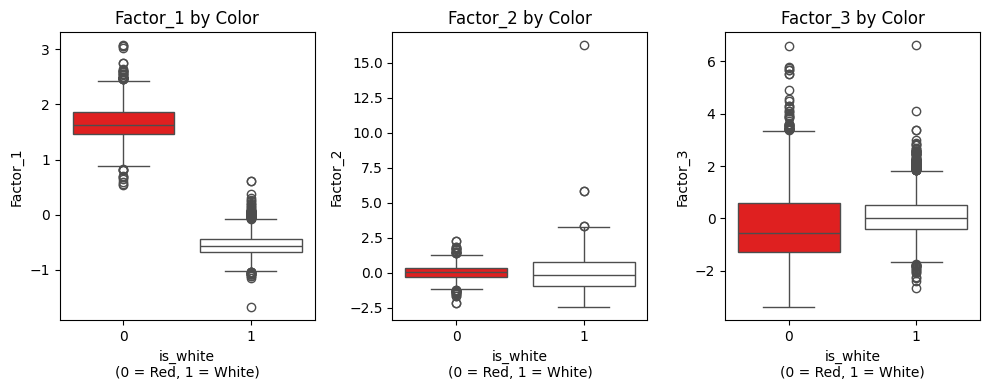

In [44]:
# Attach factor scores from FactorAnalyzer and visualize by wine color
scores_df = pd.DataFrame(fa_lib.transform(X_scaled), columns=fa_lib_loadings.columns)
df_scores = pd.concat([df[['quality', 'is_white']], scores_df], axis=1)

# Boxplot of each factor by wine color
plt.figure(figsize=(10, 4))
palette = {0: 'red', 1: 'white'}  # 0 = Red, 1 = White

for i in range(n_factors):
    plt.subplot(1, n_factors, i + 1)
    sns.boxplot(
        x='is_white',
        y=f"Factor_{i+1}",
        data=df_scores,
        hue='is_white',
        palette=palette,
        dodge=False
    )
    plt.xlabel('is_white\n(0 = Red, 1 = White)')
    plt.title(f"Factor_{i+1} by Color")
    plt.legend([], [], frameon=False)  # hide duplicate legends

plt.tight_layout()
save_plot("factor_scores_by_wine_color.png")
plt.show()


## Correlation & Scatter Plots
The correlation analysis reveals that Factor 2 has the strongest relationship with wine quality, showing a moderate negative correlation of -0.288, followed by Factor 1 with a weaker negative correlation of -0.137, and Factor 3 with a near-zero correlation (0.039). These results suggest that higher values of Factor 2 are generally associated with lower wine quality scores. The scatter plot of Factor 1 vs. Factor 2, colored by quality, visually supports this interpretation: we observe that samples with higher quality (in yellow) are more concentrated in regions with lower Factor 2 scores, while lower-quality samples (in purple) tend to occupy the opposite end. This indicates that Factor 2 may capture undesirable chemical properties that detract from perceived quality — potentially linked to attributes like high residual sugar or sulfur dioxide, which were prominent in its loadings. While Factor 1 also shows a mild inverse relationship with quality, its effect is less pronounced. Overall, the analysis suggests that the latent structures identified through Factor Analysis, particularly Factor 2, carry meaningful signals related to wine quality.


Correlation with quality:
 Factor_1   -0.137
Factor_2   -0.288
Factor_3    0.039
Name: quality, dtype: float64
✅ Saved: C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures\factor1_vs_factor2_by_quality.png


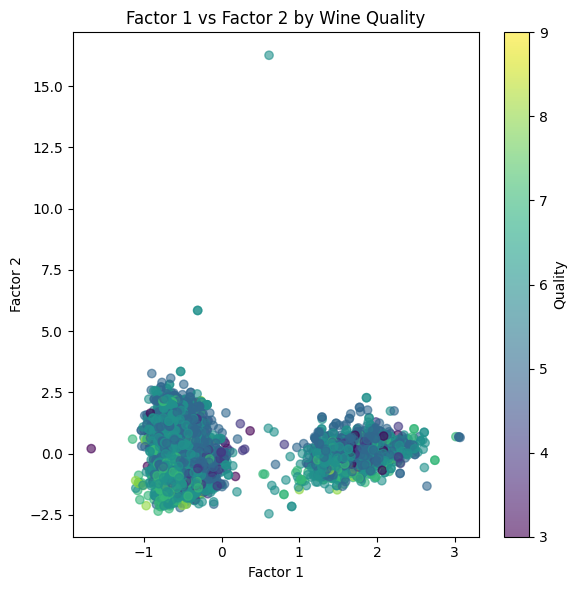

In [45]:
# Correlation with quality
corrs = df_scores.corr().loc['quality', fa_lib_loadings.columns]
print("\nCorrelation with quality:\n", corrs.round(3))

# Scatter plot: Factor 1 vs Factor 2 colored by wine quality
plt.figure(figsize=(6,6))
sc = plt.scatter(
    df_scores['Factor_1'], df_scores['Factor_2'],
    c=df_scores['quality'], cmap='viridis', alpha=0.6
)
plt.colorbar(sc, label='Quality')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Factor 1 vs Factor 2 by Wine Quality')
plt.tight_layout()
save_plot("factor1_vs_factor2_by_quality.png")  # <- Save here
plt.show()



##  Mean Score vs Quality
The plots illustrate how the average factor scores vary across different wine quality levels. We observe a clear negative trend for both Factor 1 and Factor 2, suggesting that wines with higher quality scores tend to have lower scores on these two latent dimensions. Specifically, Factor 2 shows the steepest decline, consistent with its strongest negative correlation to quality (as seen earlier). This might imply that Factor 2 captures physicochemical traits that are inversely related to perceived wine quality—possibly traits associated with higher acidity or undesirable compounds.

In contrast, Factor 3 shows a more irregular pattern, with relatively flat scores across most quality levels but a sharp increase at quality 9. This aligns with the near-zero correlation we observed earlier, indicating that Factor 3 likely captures variation that does not consistently impact quality or is only relevant at the extremes.

Overall, this analysis helps us identify which latent features are more influential in distinguishing high- versus low-quality wines, providing a dimensional summary of the dataset that aligns with human wine assessments.

✅ Saved: C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures\mean_factor_scores_by_quality.png


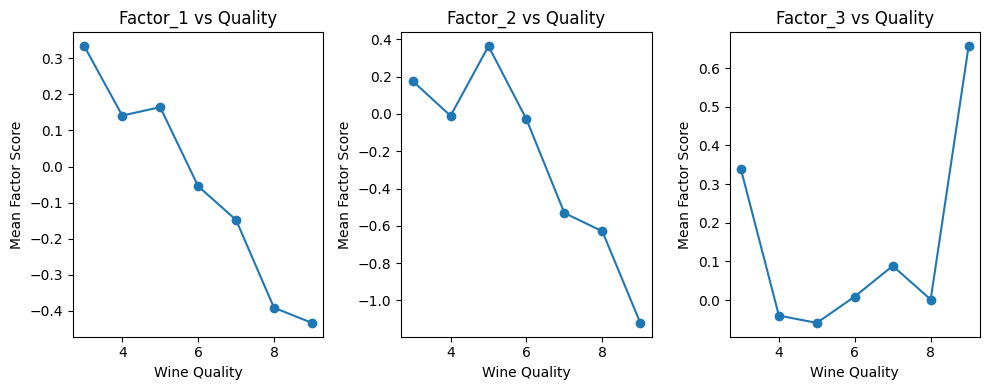

In [46]:
plt.figure(figsize=(10, 4))
for i, f in enumerate(fa_lib_loadings.columns):  # use correct columns
    plt.subplot(1, n_factors, i+1)
    mean_scores = df_scores.groupby('quality')[f].mean()
    plt.plot(mean_scores.index, mean_scores.values, marker='o')
    plt.xlabel("Wine Quality")
    plt.ylabel("Mean Factor Score")
    plt.title(f"{f} vs Quality")

plt.tight_layout()
save_plot("mean_factor_scores_by_quality.png")  
plt.show()



## Jitter Scatter vs Quality
This set of scatter plots shows the relationship between wine quality scores (x-axis) and the factor scores (y-axis) derived from our Factor Analysis model across three extracted components.

Factor 1 vs Quality: The distribution of factor scores remains somewhat uniform across wine quality levels, though the spread appears slightly narrower at higher quality levels. This suggests that Factor 1 may not be a strong differentiator of wine quality, as scores are similarly distributed across the full range of quality ratings.

Factor 2 vs Quality: There appears to be a slight downward trend in factor scores as wine quality increases, with higher-quality wines showing more concentrated and slightly lower factor scores. While there is some noise, this might indicate that Factor 2 has a modest inverse relationship with wine quality.

Factor 3 vs Quality: The distribution is more symmetrical and centered around zero, with little to no apparent pattern across quality scores. This implies that Factor 3 is likely orthogonal to the wine quality construct and does not play a strong explanatory role in differentiating quality levels.

Overall, these scatter plots visually reinforce earlier findings from correlation and mean plots: Factor 2 shows the most noticeable relationship with wine quality, albeit weakly negative, while Factors 1 and 3 exhibit minimal direct correlation with quality


✅ Saved: C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures\factor_score_scatter_vs_quality.png


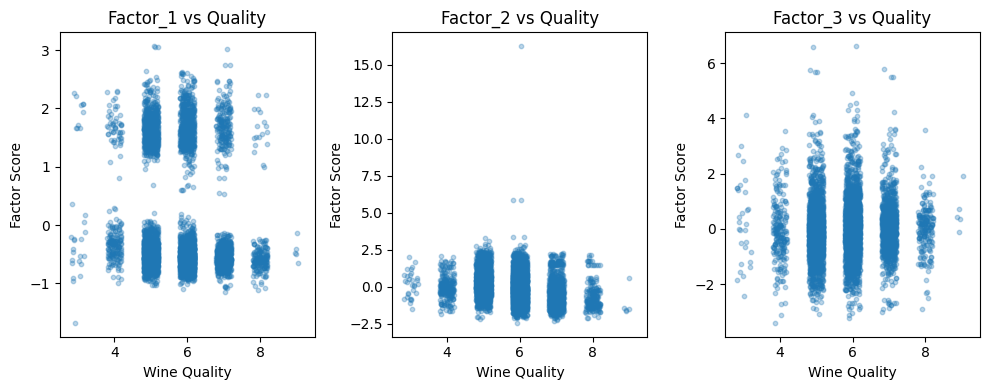

In [47]:
plt.figure(figsize=(10, 4))
for i, f in enumerate(fa_lib_loadings.columns):
    plt.subplot(1, n_factors, i + 1)
    x = df_scores['quality'] + np.random.uniform(-0.2, 0.2, size=len(df_scores))
    plt.scatter(x, df_scores[f], alpha=0.3, s=10)
    plt.title(f"{f} vs Quality")
    plt.xlabel("Wine Quality")
    plt.ylabel("Factor Score")
    plt.xlim(2.5, 9.5)

plt.tight_layout()
save_plot("factor_score_scatter_vs_quality.png") 
plt.show()

## Predict Quality
## Poissin GLM
In this Poisson regression model, we aim to model the expected wine quality score as a function of three latent factors derived from our earlier factor analysis. Since the Poisson model uses a log link, each coefficient represents the expected change in the log of the mean quality score for a one-unit increase in the respective factor, holding all else constant. To interpret these effects on the original scale, we exponentiate the coefficients, yielding incident rate ratios (IRRs) — multiplicative changes in the expected count (wine quality) per unit increase in each factor.

The results show that Factor_1 has a coefficient of −0.0205, which translates to an IRR of 0.980. This means that for each one-unit increase in Factor_1, the expected wine quality decreases by approximately 2%, suggesting Factor_1 is negatively associated with wine quality. Similarly, Factor_2 has a stronger negative effect with a coefficient of −0.0435 and an IRR of 0.957, indicating a 4.3% decrease in expected quality for each additional unit of Factor_2. These effects are statistically significant (p < 0.001). In contrast, Factor_3 has a small positive coefficient (0.0063) and an IRR of 1.006, implying a 0.6% increase in expected quality per unit increase in Factor_3, but this effect is not statistically significant (p = 0.23).

Model diagnostics show a log-likelihood of −12132, and a deviance of 766.48, with a corresponding Pearson chi-squared statistic of 761. The closeness between deviance and Pearson χ² indicates a reasonably good model fit, especially under the assumption of equidispersion. The pseudo R² (Cragg–Uhler) is 0.013, which is modest but expected given the inherent complexity and noise in subjective quality ratings. Overall, the model captures significant, interpretable relationships between underlying wine characteristics (as reduced to factors) and perceived quality, while acknowledging that much of the variability in ratings remains unexplained.

In [38]:
Xf = df_scores[['Factor_1','Factor_2','Factor_3']]
y  = df_scores['quality']


Xf_const = sm.add_constant(Xf)  # Add intercept
poisson_model = sm.GLM(y, Xf_const, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Exponentiate coefficients to interpret as multiplicative effects
exp_coefs = np.exp(poisson_model.params)
print("\nExponentiated coefficients (IRRs):\n", exp_coefs.round(3))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 6497
Model:                            GLM   Df Residuals:                     6493
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12132.
Date:                Fri, 09 May 2025   Deviance:                       766.48
Time:                        20:03:59   Pearson chi2:                     761.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01337
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7599      0.005    341.766      0.0

## XGBoost(Poisson)
This output presents the performance of an XGBoost Regressor trained using the Poisson loss function (objective='count:poisson') to predict wine quality based on the three latent factors (Factor_1, Factor_2, Factor_3). The goal here is to assess how well this nonlinear, tree-based method captures the relationship between these factor scores and the observed quality ratings.

The model achieved an R² of 0.592, meaning it explains approximately 59.2% of the variance in wine quality scores. This is substantially higher than the pseudo R² of 0.013 from the earlier Poisson GLM, indicating that the XGBoost model is far better at capturing complex, nonlinear interactions among the factors.

In terms of error metrics:

    The Mean Squared Error (MSE) is 0.311, suggesting relatively low average squared deviations from the true quality scores.

    The Mean Absolute Error (MAE) is 0.442, meaning the model’s predictions differ from the actual wine quality by about 0.44 points on average, which is quite reasonable considering the 0–10 scale.

Overall, this result shows that while the Poisson GLM is more interpretable, the XGBoost Poisson model offers significantly improved predictive performance, likely due to its ability to model nonlinear relationships and interactions not captured in the linear framework. This trade-off between interpretability and performance is common in statistical learning applications.


In [39]:
xgb = XGBRegressor(objective='count:poisson', n_estimators=100, random_state=42)
xgb.fit(Xf, y)
y_pred = xgb.predict(Xf)

# Metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = xgb.score(Xf, y)

print(f"\nXGBoost Poisson Performance:")
print(f"  R²:  {r2:.3f}")
print(f"  MSE: {mse:.3f}")
print(f"  MAE: {mae:.3f}")


XGBoost Poisson Performance:
  R²:  0.592
  MSE: 0.311
  MAE: 0.442



## Clustering
Each cluster represents a group of wines that share similar patterns across the extracted factors, and the accompanying cluster profile table provides a breakdown:

    Cluster 0 (n = 2,062):
    Has a mean quality score of 5.622, slightly below average, with a strongly negative Factor_1 mean (−0.596) and the highest Factor_2 mean (1.063), suggesting high values for attributes contributing to Factor_2, and low values for those in Factor_1. Factor_3 is near zero.

    Cluster 1 (n = 2,772):
    The largest cluster, with a higher mean quality of 6.089. It is characterized by low scores on both Factor_1 (−0.518) and Factor_2 (−0.812), indicating that it may contain wines with lower concentrations of the components loading positively on those factors. This cluster likely includes many of the higher-quality white wines.

    Cluster 2 (n = 502):
    This smallest cluster has a quality mean of 5.745, with very high Factor_1 (1.754) and Factor_3 (1.835) scores. It likely contains a unique subset of wines with elevated characteristics related to both factors, suggesting complexity or unusual composition.

    Cluster 3 (n = 1,161):
    Displays the lowest quality mean (5.553) and is defined by high Factor_1 (1.536) but strongly negative Factor_3 (−0.987), implying high intensity in attributes linked to Factor_1 but suppressed characteristics related to Factor_3.

Best Clustering → k=4.0, n_init=20.0, silhouette=0.449

Cluster profile:
              quality_count  quality_mean  Factor_1_mean  Factor_2_mean  \
cluster_opt                                                              
0                     2062         5.622         -0.596          1.063   
1                     2772         6.089         -0.518         -0.812   
2                      502         5.745          1.754          0.043   
3                     1161         5.553          1.536          0.033   

             Factor_3_mean  
cluster_opt                 
0                    0.011  
1                    0.073  
2                    1.835  
3                   -0.987  
✅ Saved: C:/Users/lukew/OneDrive/Desktop/Lukas/Python/wine-quality-analysis/figures\kmeans_clusters_by_factors.png


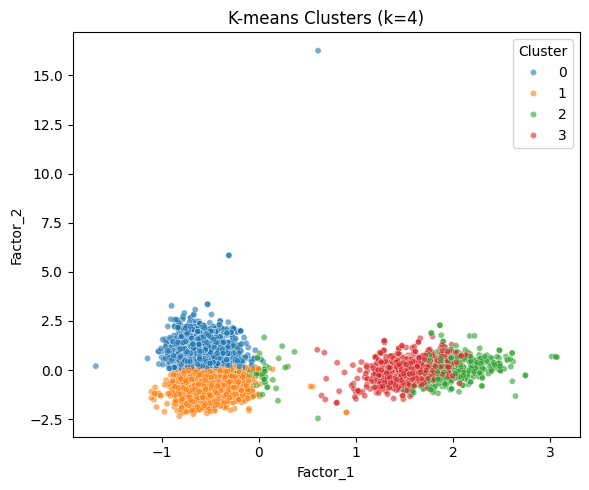

In [48]:
records = []
for k in range(2, 11):
    for n_init in (5, 10, 20):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=42)
        lbl = km.fit_predict(Xf)
        records.append({'k': k, 'n_init': n_init, 'silhouette': silhouette_score(Xf, lbl)})

tune_df = pd.DataFrame(records).sort_values('silhouette', ascending=False)
best_row = tune_df.iloc[0]
print(f"Best Clustering → k={best_row.k}, n_init={best_row.n_init}, silhouette={best_row.silhouette:.3f}")

km_opt = KMeans(n_clusters=int(best_row.k), n_init=int(best_row.n_init), random_state=42)
df_scores['cluster_opt'] = km_opt.fit_predict(Xf)

profile = df_scores.groupby('cluster_opt').agg({
    'quality': ['count','mean'],
    'Factor_1':'mean','Factor_2':'mean','Factor_3':'mean'
})
profile.columns = ["_".join(c) for c in profile.columns]
print("\nCluster profile:\n", profile.round(3))

plt.figure(figsize=(6,5))
sns.scatterplot(x='Factor_1', y='Factor_2', hue='cluster_opt', palette='tab10', data=df_scores, alpha=0.6, s=20)
plt.title(f"K-means Clusters (k={int(best_row.k)})")
plt.legend(title="Cluster")
plt.tight_layout()
save_plot( "kmeans_clusters_by_factors.png") 
plt.show()


## Conclusion
This clustering reveals meaningful structure in the latent factor space. Factor_1 appears to drive the most visible separation between clusters, and differences in mean quality across clusters suggest that latent dimensions derived from the factor analysis help explain variations in perceived wine quality. Clusters with higher Factor_1 and Factor_3 values (like Cluster 2) are associated with better quality, while those with more negative scores (like Cluster 3) tend toward lower ratings.